In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

In [5]:
SAMPLES_CSV = "data/samples_step1_person_limited.csv"
PROC_ROOT   = "data/processed_step2"  

CONDITION = "orig_full"

BATCH_SIZE = 16
NUM_EPOCHS = 5
LR = 1e-3
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [6]:
df = pd.read_csv(SAMPLES_CSV)

# {image_id}_{ann_id}.jpg
df["img_file"] = df.apply(
    lambda r: f"{int(r.image_id)}_{int(r.ann_id)}.jpg",
    axis=1
)

df["cond_path"] = df["img_file"].apply(
    lambda f: os.path.join(PROC_ROOT, CONDITION, f)
)

# Prepare class labels for multi-class classification
classes = sorted(df["category_name"].unique().tolist())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

df["label"] = df["category_name"].map(class_to_idx).astype(int)

print("Number of samples:", len(df))
print("Classes:", classes)

df[["category_name", "label"]].drop_duplicates().sort_values("label")


Number of samples: 600
Classes: ['bicycle', 'bus', 'car', 'motorcycle', 'person', 'truck']


,category_name,label
86,bicycle,0
72,bus,1
70,car,2
71,motorcycle,3
0,person,4
81,truck,5


In [7]:
rng = np.random.RandomState(SEED)

train_idx = []
val_idx = []

for c in classes:
    sub_idx = df[df["category_name"] == c].index.to_numpy()
    rng.shuffle(sub_idx)

    # 20% for validation
    n_val = max(1, int(0.2 * len(sub_idx)))
    val_idx.extend(sub_idx[:n_val])
    train_idx.extend(sub_idx[n_val:])

train_df = (
    df.loc[train_idx]
      .sample(frac=1, random_state=SEED)
      .reset_index(drop=True)
)

val_df = (
    df.loc[val_idx]
      .sample(frac=1, random_state=SEED)
      .reset_index(drop=True)
)

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))

print("\nTrain class distribution:")
print(train_df["category_name"].value_counts())

print("\nValidation class distribution:")
print(val_df["category_name"].value_counts())

Train samples: 482
Validation samples: 118

Train class distribution:
category_name
person        168
car           152
motorcycle     58
truck          43
bus            36
bicycle        25
Name: count, dtype: int64

Validation class distribution:
category_name
person        42
car           38
motorcycle    14
truck         10
bus            8
bicycle        6
Name: count, dtype: int64


In [8]:
# Pytorch dataset
class CocoCondDataset(Dataset):
    """
    Each sample returns:
        - image tensor
        - class label (int)
        - size_group (small / medium / large)
        - category_name
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        # get one row from df
        row = self.df.iloc[index]
        path = row["cond_path"]

        img_bgr = cv2.imread(path)
        if img_bgr is None:
            raise RuntimeError(f"Failed to read image: {path}")
        
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # apply torchvision transforms
        if self.transform is not None:
            img = self.transform(img_rgb)
        else:
            img = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

        label = int(row["label"])

        size_group = row["size_group"]

        return img, label, size_group, row["category_name"]

In [9]:
# include random horizontal flip for data augmentation
train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),         
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],       
        std=[0.229, 0.224, 0.225]          
    )
])

val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [10]:
train_ds = CocoCondDataset(train_df, transform=train_tf)
val_ds   = CocoCondDataset(val_df, transform=val_tf)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [11]:
num_classes = len(classes)

model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

# Freeze all backbone parameters, Only final classifier layer trained
for p in model.parameters():
    p.requires_grad = False

# Replace final fully-connected layer for this project
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LR)

In [12]:
def run_epoch(model, loader, train=True):
    """
    Returns:
        - average loss
        - accuracy
        - predictions
        - ground-truth labels
        - size_group list
    """
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total = 0
    correct = 0

    # Collect predictions
    all_preds = []
    all_labels = []
    all_sizes = []

    for imgs, labels, size_groups, _cat_names in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(train):
            logits = model(imgs)
            loss = criterion(logits, labels)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total += imgs.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()

        # Store results for size_group
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())
        all_sizes.extend(list(size_groups))

    # Compute average loss and accuracy
    avg_loss = total_loss / max(1, total)
    acc = correct / max(1, total)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return avg_loss, acc, all_preds, all_labels, all_sizes

In [13]:
train_hist = []
val_hist = []

for epoch in range(1, NUM_EPOCHS + 1):
    # Train for one epoch
    tr_loss, tr_acc, *_ = run_epoch(
        model, train_loader, train=True
    )

    # Evaluate on validation set
    va_loss, va_acc, va_preds, va_labels, va_sizes = run_epoch(
        model, val_loader, train=False
    )

    # Store training history
    train_hist.append((tr_loss, tr_acc))
    val_hist.append((va_loss, va_acc))

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
        f"val loss {va_loss:.4f} acc {va_acc:.3f}"
    )

Epoch 01 | train loss 1.5154 acc 0.402 | val loss 1.3278 acc 0.492
Epoch 02 | train loss 1.3089 acc 0.519 | val loss 1.2532 acc 0.568
Epoch 03 | train loss 1.1652 acc 0.583 | val loss 1.2147 acc 0.568
Epoch 04 | train loss 1.1228 acc 0.598 | val loss 1.1779 acc 0.559
Epoch 05 | train loss 1.0123 acc 0.645 | val loss 1.2316 acc 0.517


In [14]:
from collections import defaultdict

def accuracy_by_group(preds, labels, groups):
    d = defaultdict(lambda: [0,0])  # group -> [correct, total]
    for p, y, g in zip(preds, labels, groups):
        d[g][1] += 1
        if p == y:
            d[g][0] += 1

    # group -> (acc, correct, total)
    result = {g: (c/t if t>0 else 0.0, c, t) for g,(c,t) in d.items()}
    return result

acc_group = accuracy_by_group(va_preds, va_labels, va_sizes)
acc_group

{'medium': (0.4864864864864865, 18, 37),
 'small': (0.41304347826086957, 19, 46),
 'large': (0.6857142857142857, 24, 35)}

small : acc=0.413 (19/46)
medium: acc=0.486 (18/37)
large : acc=0.686 (24/35)


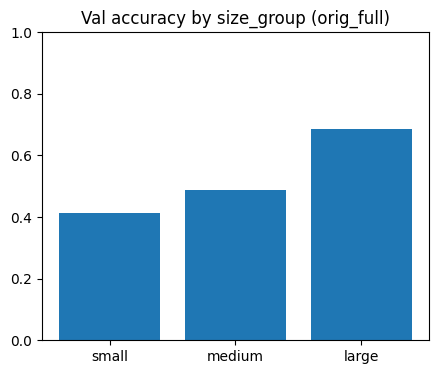

In [15]:
groups = ["small", "medium", "large"]
accs = [acc_group.get(g,(0,0,0))[0] for g in groups]

for g in groups:
    a, c, t = acc_group.get(g,(0,0,0))
    print(f"{g:6s}: acc={a:.3f} ({c}/{t})")

plt.figure(figsize=(5,4))
plt.bar(groups, accs)
plt.title(f"Val accuracy by size_group ({CONDITION})")
plt.ylim(0, 1)
plt.show()

The result shows a clear performance gap across object sizes. Accuracy increases as object size becomes larger. This trend indicates that the CNN struggles more with small objects even under the original, unmodified condition. It suggests that limited spatial resolution and background clutter already affect small object recognition before applying additional degradations.

In [16]:
def prepare_df_for_condition(df_base, condition):
    df2 = df_base.copy()
    df2["img_file"] = df2.apply(lambda r: f"{int(r.image_id)}_{int(r.ann_id)}.jpg", axis=1)
    df2["cond_path"] = df2["img_file"].apply(lambda f: os.path.join(PROC_ROOT, condition, f))
    df2 = df2[df2["cond_path"].apply(os.path.exists)].copy()
    df2["label"] = df2["category_name"].map(class_to_idx).astype(int)
    return df2.reset_index(drop=True)

results = []

for cond in ["orig_full", "orig_crop", "downscale", "motion_blur", "occlusion", "bg_blur"]:
    # rebuild loaders for this condition
    df_cond = prepare_df_for_condition(pd.read_csv(SAMPLES_CSV), cond)

    # split per class
    rng = np.random.RandomState(SEED)
    tr_idx, va_idx = [], []
    for c in classes:
        sub = df_cond[df_cond["category_name"] == c].index.to_numpy()
        rng.shuffle(sub)
        n_val = max(1, int(0.2 * len(sub)))
        va_idx.extend(sub[:n_val]); tr_idx.extend(sub[n_val:])

    train_df_c = df_cond.loc[tr_idx].sample(frac=1, random_state=SEED).reset_index(drop=True)
    val_df_c   = df_cond.loc[va_idx].sample(frac=1, random_state=SEED).reset_index(drop=True)

    train_ds_c = CocoCondDataset(train_df_c, transform=train_tf)
    val_ds_c   = CocoCondDataset(val_df_c, transform=val_tf)

    train_loader_c = DataLoader(train_ds_c, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_c   = DataLoader(val_ds_c, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # fresh model each condition for fair comparision
    model_c = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    for p in model_c.parameters():
        p.requires_grad = False
    model_c.fc = nn.Linear(model_c.fc.in_features, num_classes)
    model_c = model_c.to(device)

    optimizer_c = torch.optim.Adam(model_c.fc.parameters(), lr=LR)

    # train a few epochs
    global optimizer
    optimizer = optimizer_c
    for _ in range(NUM_EPOCHS):
        run_epoch(model_c, train_loader_c, train=True)

    # eval
    va_loss, va_acc, va_preds, va_labels, va_sizes = run_epoch(model_c, val_loader_c, train=False)
    acc_group = accuracy_by_group(va_preds, va_labels, va_sizes)

    results.append({
        "condition": cond,
        "val_acc_all": va_acc,
        "val_acc_small": acc_group.get("small",(0,0,0))[0],
        "val_acc_medium": acc_group.get("medium",(0,0,0))[0],
        "val_acc_large": acc_group.get("large",(0,0,0))[0],
    })

res_df = pd.DataFrame(results)
res_df


,condition,val_acc_all,val_acc_small,val_acc_medium,val_acc_large
0,orig_full,0.584746,0.543478,0.540541,0.685714
1,orig_crop,0.635593,0.565217,0.594595,0.771429
2,downscale,0.576271,0.521739,0.513514,0.714286
3,motion_blur,0.542373,0.391304,0.621622,0.657143
4,occlusion,0.516949,0.521739,0.432432,0.600000
5,bg_blur,0.550847,0.391304,0.486486,0.828571


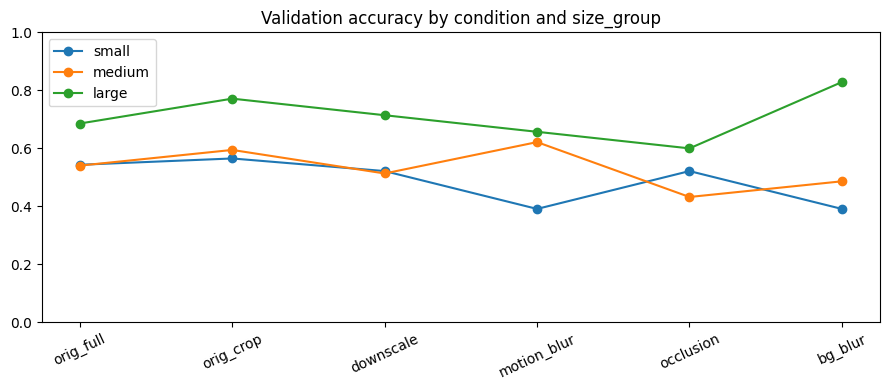

In [17]:
plt.figure(figsize=(9,4))
plt.plot(res_df["condition"], res_df["val_acc_small"], marker="o", label="small")
plt.plot(res_df["condition"], res_df["val_acc_medium"], marker="o", label="medium")
plt.plot(res_df["condition"], res_df["val_acc_large"], marker="o", label="large")
plt.xticks(rotation=25)
plt.ylim(0, 1)
plt.title("Validation accuracy by condition and size_group")
plt.legend()
plt.tight_layout()
plt.show()

The results show consistent performance gaps across object sizes under all conditions. Large objects achieve the highest accuracy in every condition, while small objects remain the most challenging.

Cropping the object region significantly improves accuracy for small objects, suggesting that background clutter strongly affects small-object recognition. In contrast, degradations such as downscale and motion blur cause a clear drop in nsmall-object accuracy, while large objects are relatively robust.

Overall, these results indicate that CNN performance degradation under challenging conditions disproportionately impacts small objects, mainly due to limited spatial resolution and reliance on background context.

In [18]:
RESULTS_CSV = "data/results_conditions.csv"
os.makedirs(os.path.dirname(RESULTS_CSV), exist_ok=True)

res_df.to_csv(RESULTS_CSV, index=False)
print("Saved:", RESULTS_CSV)

Saved: data/results_conditions.csv


In [19]:
import os, torch

CKPT_PATH = "data/step3_checkpoint.pth"
os.makedirs(os.path.dirname(CKPT_PATH), exist_ok=True)

torch.save({
    "model_state_dict": model.state_dict(),
    "idx_to_class": idx_to_class,
    "class_to_idx": class_to_idx,
    "classes": classes,
    "condition": CONDITION,
    "seed": SEED,
}, CKPT_PATH)

print("Saved checkpoint:", CKPT_PATH)

Saved checkpoint: data/step3_checkpoint.pth
